In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.display import display_markdown
import pickle
from joblib import dump, load
import time

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [19]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=DM+Sans:ital,opsz,wght@0,9..40,100..1000;1,9..40,100..1000&display=swap');
div.text_cell {font-family : DM Sans, sans-serif !important;}
pre {font-family : DM Sans, sans-serif !important;}
</style>

# **Regression Model Comparison Template** 
This Notebook compares the performance of different types of regression models on a dataset provided by the user. It is meant to assist in the model selection process by helping users discern the most suitible regression model for their dataset. Throughout the template there are global variables that the user must configure which represent characteristics of the dataset. Unchanging characteristics like the name of the data file are represented with capitalized constant variables. Users should store data in the data directory.
## **Regression Analysis**
Regression refers to statistical methods for analyzing the relationship between dependent and independent variables. In machine learning, regression analysis is implimented as supervised learning algorithms used to identify the relationships between dependent variables called targets and predictive independent variables called features. 

In this example, the regression models are evaluated on a kaggle dataset that contains eight columns which describe characteristics of diamonds, such as their cut, color, clarity, and dimensions. The target variable is the price of the diamond.

## **Load in a Dataset and Select Columns to Drop**

In [78]:
DATA_FILE_NAME: str = "regression_diamond_data.csv" 
COLUMNS_TO_DROP: list[str] = [] 


def load_data(file_name: str = DATA_FILE_NAME, dropped_columns = COLUMNS_TO_DROP) -> pd.DataFrame:
    """
    Loads in user's input file as a pandas DataFrame.
    
    Params:
        file_name (str): Name of file containing data for clustering
        dropped_columns (list[str]): List of columns to drop from the dataframe
    Returns:
        pd.DataFrame: Dataframe of feature variable values for all data entries
    """
    
    file_name = "data/" + file_name
    file_extension = file_name.split(".")[-1]

    if file_extension == "csv":
        df = pd.read_csv(file_name)
    elif file_extension in ["xls", "xlsx"]:
        df = pd.read_excel(file_name)
    elif file_extension == "json":
        df = pd.read_json(file_name)
    else:
        raise ValueError("Unsupported file format or misspelled file name. Please upload a CSV, Excel, or JSON file and ensure the file name is spelled correctly.")
    
    df.drop_duplicates(inplace = True)
    df.drop(columns = dropped_columns, inplace = True)
    
    return df

data_df = load_data()
total_number_of_entries = len(data_df)
display_markdown(md(f"### **Number of Entries:** {total_number_of_entries}"))
data_df.head()

### **Number of Entries:** 53644

carat      cut color clarity  price     x     y     z
0   0.23    Ideal     E     SI2    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1    326  3.89  3.84  2.31
2   0.23     Good     E     VS1    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2    334  4.20  4.23  2.63
4   0.31     Good     J     SI2    335  4.34  4.35  2.75

### **Dataset Missing Values Information**

In [135]:
numerical_columns: list[str] = list(data_df.select_dtypes(include = np.number).columns)
display_markdown(md(f"### **Numerical Columns:** {numerical_columns}"))

categorical_columns: list[str] = list(data_df.select_dtypes(exclude = np.number).columns)
display_markdown(md(f"### **Categorical Columns:** {categorical_columns}"))

# Automatically select columns with missing values
numerical_columns_with_missing_values: list[str] = data_df[numerical_columns].columns[data_df[numerical_columns].isnull().any()].tolist()
categorical_columns_with_missing_values: list[str] = data_df[categorical_columns].columns[data_df[categorical_columns].isnull().any()].tolist()
all_columns_with_missing_values: list[str] = numerical_columns_with_missing_values + categorical_columns_with_missing_values


if len(all_columns_with_missing_values) != 0:
    print()
    # The next two if statements show the missing value type for each column with missing values,
    # a necessary argument for imputation functions. Only works if missing value is either np.nan or None.
    if len(categorical_columns_with_missing_values) != 0:    
        display_markdown(md(f"### **Missing Value Type for Categorical Columns with Missing Values (either np.nan or None)**"))
        
        for column in categorical_columns_with_missing_values:
            missing_values = data_df[column][data_df[column].isnull()]
            missing_type = type(missing_values.iloc[0])
            
            if pd.isna(missing_values.iloc[0]):
                display_markdown(md(f"* #### **{column}**: np.nan"))
            else:
                display_markdown(md(f"* #### **{column}**: {str(missing_type)}"))
    
    if len(numerical_columns_with_missing_values) != 0:
        display_markdown(md(f"### **Missing Value Type for Numerical Columns with Missing Values (either np.nan or None)**"))
        
        for column in categorical_columns_with_missing_values:
            missing_values = data_df[column][data_df[column].isnull()]
            missing_type = type(missing_values.iloc[0])
            
            if pd.isna(missing_values.iloc[0]):
                display_markdown(md(f"* #### **{column}**: np.nan"))
            else:
                display_markdown(md(f"* #### **{column}**: {str(missing_type)}"))
                
    
    print()
    entries_with_missing_values_df: pd.DataFrame = data_df[all_columns_with_missing_values][data_df[all_columns_with_missing_values].isnull().any(axis = "columns")]
    number_of_entries_with_missing_values: int = len(entries_with_missing_values_df)
    percent_of_entries_with_missing_values: float = (number_of_entries_with_missing_values / total_number_of_entries) * 100
    total_number_of_missing_values: int = data_df[all_columns_with_missing_values].isnull().sum().sum()
    
    display_markdown(md(f"### **Missing Values by Columns**"))
    
    for column in all_columns_with_missing_values:
        column_missing_values: int = data_df[column].isnull().sum()
        percent_missing_values: float = (column_missing_values / total_number_of_entries) * 100
        
        if column_missing_values != 0:
            display_markdown(md(f"* #### **{column}**: {column_missing_values} ({percent_missing_values:.2f}% of Entries)"))
        
    print()
    display_markdown(md(f"### **Toatl Number of Entries:** {total_number_of_entries}"))
    display_markdown(md(f"### **Total Number of Entreis with at Least One Missing Value:** {number_of_entries_with_missing_values} ({percent_of_entries_with_missing_values:.2f}% of Entries)"))
    display_markdown(md(f"### **Total Number of Missing Values:** {total_number_of_missing_values}"))
    display_markdown(md(f"### **Number of Entries if all Rows with Missing Values are Dropped:** {total_number_of_entries - number_of_entries_with_missing_values}"))
    print()
    display_markdown(md("### Up to First 10 Entries with Missing Values"))
    display(entries_with_missing_values_df.head(10))
else:
    print()
    display_markdown(md("### **No Missing Values in Dataset**"))

### **Numerical Columns:** ['carat', 'price', 'x', 'y', 'z']

### **Categorical Columns:** ['cut', 'color', 'clarity']

### **No Missing Values in Dataset**

## **Handle Missing Values and Seperate Target and Feature Columns**
### Chose between dropping or imputing missing values.
#### Use the drop_rows_with_missing_values function if there are no missing values in the dataset to seperate target and feature columns. 
#### If you chose to impute missing values, edit the imputute_missing_values function to suite your use case (such as choosing columns to impute and specifying between imputing with the mean, median, or mode of the column). The given imputute_missing_values function is applied to all columns with missing values. Missing numerical values are imputed with the median of the column and missing categorical values are imputed with the mode of the column.

In [83]:
TARGET_COLUMN_NAME: str = "price"
TARGET_VARIABLE_NAME: str = TARGET_COLUMN_NAME # Name of target variable to use when displaying results, often the same as TARGET_COLUMN_NAME


def drop_rows_with_missing_values(df: pd.DataFrame = data_df, target_variable_comlumn: str = TARGET_COLUMN_NAME) -> tuple[pd.DataFrame, pd.Series]:
    """
    Drops all rows with missing values from the DataFrame and splits dataset into feature dataframe and target series.
    Also prints number of entries of returned feature dataframe and target series to ensure they are equal.
    
    Params:
        df (pd.DataFrame): DataFrame containing loded in data
        target_variable_comlumn (str): Name of the target variable column
    Returns:
        tuple[pd.DataFrame, pd.Series]: tuple containing the feature dataframe and target series with missing values dropped
    """
    
    dropna_df = df.dropna()
    
    features_df = dropna_df.drop(columns = target_variable_comlumn)
    target_series = dropna_df[target_variable_comlumn]
    display_markdown(md(f"### drop_rows_with_missing_values Results:"))
    display_markdown(md(f"* ### Number of Entries in Features DataFrame: {len(features_df)}"))
    display_markdown(md(f"* ### Number of Entries in Target Series: {len(target_series)}"))
    
    return (features_df, target_series)


def impute_missing_values(df: pd.DataFrame = data_df.copy(),
                          target_variable_column: str = TARGET_COLUMN_NAME,
                          numerical_columns_to_impute: list[str] = numerical_columns_with_missing_values,
                          categorical_columns_to_impute: list[str] = categorical_columns_with_missing_values) -> tuple[pd.DataFrame, pd.Series]:
    """
    Imputes missing values in the DataFrame with either the median value (for numerical features) or the most frequent value (for categorical features)
    and splits dataset into feature dataframe and target series. Also prints number of entries of returned feature dataframe and target series to ensure they are equal.
    
    Params:
        df (pd.DataFrame): DataFrame containing loded in data. Pass in a copy of the original DataFrame if you want to keep the original DataFrame unchanged.
        target_variable_column (str): Name of the target variable column
    Returns:
        pd.DataFrame: tuple[pd.DataFrame, pd.Series]: tuple containing the feature dataframe and target series with missing values imputed
    """
    
    numerical_imputer = SimpleImputer(strategy = "median")
    categorical_imputer = SimpleImputer(strategy = "most_frequent")
    
    df[numerical_columns_to_impute] = numerical_imputer.fit_transform(df[numerical_columns_to_impute])
    df[categorical_columns_to_impute] = categorical_imputer.fit_transform(df[categorical_columns_to_impute])
    
    features_df = df.drop(columns = target_variable_column)
    target_series = df[target_variable_column]
    display_markdown(md(f"### impute_missing_values Results:"))
    display_markdown(md(f"* ### Number of Entries in Features DataFrame : {len(features_df)}"))
    display_markdown(md(f"* ### Number of Entries in Target Series: {len(target_series)}"))
    
    return (features_df, target_series)


dropna_X, dropna_y = drop_rows_with_missing_values()

FEATURE_LIST = list(dropna_X.columns)
NUM_FEATURES = len(FEATURE_LIST)

### drop_rows_with_missing_values Results:

* ### Number of Entries in Features DataFrame: 53644

* ### Number of Entries in Target Series: 53644

## **Setup Preprocessing**

### **Dataset Preprocessing Information**

In [85]:
display_markdown(md(f"### **Numerical Columns:** {numerical_columns}"))
display_markdown(md(f"### **Categorical Columns:** {categorical_columns}"))

if len(categorical_columns) != 0:
    print()
    display_markdown(md("### **Unique Entries for Categorical Columns**"))
    
    for column in categorical_columns:
        unique_entries = list(data_df[column].unique())
        display_markdown(md(f"* #### **{column}** Column: {unique_entries}"))

data_df.head()

### **Numerical Columns:** ['carat', 'price', 'x', 'y', 'z']

### **Categorical Columns:** ['cut', 'color', 'clarity']

### **Unique Entries for Categorical Columns**

* #### **cut** Column: ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']

* #### **color** Column: ['E', 'I', 'J', 'H', 'F', 'G', 'D']

* #### **clarity** Column: ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']

carat      cut color clarity  price     x     y     z
0   0.23    Ideal     E     SI2    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1    326  3.89  3.84  2.31
2   0.23     Good     E     VS1    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2    334  4.20  4.23  2.63
4   0.31     Good     J     SI2    335  4.34  4.35  2.75

### **Preprocessing Steps**
#### Edit the preprocessing steps to suit your dataset. The preprocessing steps for the feature dataframe are composed with the make_pipeline function to load in models, so combine them with a function such as ColumnTransformer to create a single preprocessing variable.
#### Preprocessing for the target series must be done separately from the feature dataframe. The target preprocessing steps will be applied directly to the y_train and y_test sets when splits are created.

In [110]:
numerical_features_to_scale: list[str] = list(set(numerical_columns) - set([TARGET_COLUMN_NAME]))
nominal_categorical_features_to_encode: list[str] = []

# Order ordinal variable categories from lowest to highest 
ordianl_categories_ordered_dict: dict[str, list[str]] = {
    "cut": ["Fair", "Good", "Very Good", "Premium", "Ideal"],
    "color": ["J", "I", "H", "G", "F", "E", "D"],
    "clarity": ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
}
ordianl_features_categories_to_encode: list[str] = list(ordianl_categories_ordered_dict.keys())
ordianl_features_categories_orders_lists: list[list[str]] = list(ordianl_categories_ordered_dict.values())

# Indicates that the first column of one-hot encoded variables should be dropped to avoid multicollinearity
onehot_drop_column = "first"


# Pass in a list of tuples containing a name for the transformer (decide a name, allows transformer parameters to be searched in grid search),
# the transformer object, and the columns to apply the transformer to
general_feature_preprocessor = ColumnTransformer(
    transformers = [
        ('numerical_scaler', StandardScaler(), numerical_features_to_scale),
        ('nominal_encoder', OneHotEncoder(drop = onehot_drop_column), nominal_categorical_features_to_encode),
        ("ordinal_encoder", OrdinalEncoder(categories = ordianl_features_categories_orders_lists), ordianl_features_categories_to_encode)
    ]
)

# Setup target preprocessor
numerical_target_preprocessor = StandardScaler()

display_markdown(md(f"### **Scaled Numerical Features:** {numerical_features_to_scale}"))
display_markdown(md(f"### **Encoded Nominal Categorical Features:** {nominal_categorical_features_to_encode}"))
display_markdown(md(f"### **Encoded Ordinal Categorical Features (confirm that category orders were assigned to the correct ordinal categorical feature):**"))
for i in range(len(ordianl_features_categories_to_encode)):
    display_markdown(md(f"* #### **{ordianl_features_categories_to_encode[i]}:** {ordianl_features_categories_orders_lists[i]}"))

### **Scaled Numerical Features:** ['x', 'y', 'carat', 'z']

### **Encoded Nominal Categorical Features:** []

### **Encoded Ordinal Categorical Features (confirm that category orders were assigned to the correct ordinal categorical feature):**

* #### **cut:** ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

* #### **color:** ['J', 'I', 'H', 'G', 'F', 'E', 'D']

* #### **clarity:** ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

## **Load In Models and Set Hyperparameters**
#### Define the functions for loading each model. Use the make_pipeline function to combine the preprocessing steps with the model and set the hyperparameters for each model to be optimized by GridSearchCV.
#### The make_pipeline function changes the way you have to input values in each models param_grid. In order for GridSearchCV to work with the make_pipline function, model hyeperparameter keys must be prefixed with the model name followed by two underscores (ex: the hyperparameter for the Lasso Regression model is "lasso__alpha" instead of just "alpha").


In [112]:
def load_linear_model() -> dict[str, dict]:
    model_data = {
        'Linear': {
            'model': make_pipeline(general_feature_preprocessor, LinearRegression()),
            'param_grid': {}  
        }
    }
    return model_data

def load_lasso_model() -> dict[str, dict]:
    alpha_values = np.linspace(0.01, 100, num = 100)
    
    model_data = {
        'Lasso': {
            'model': make_pipeline(general_feature_preprocessor, Lasso()),
            'param_grid': {'lasso__alpha': alpha_values}
        }
    }
    return model_data

def load_ridge_model() -> dict[str, dict]:
    alpha_values = np.linspace(0.01, 100, num = 100)
    
    model_data = {
        'Ridge': {
            'model': make_pipeline(general_feature_preprocessor, Ridge()),
            'param_grid': {'ridge__alpha': alpha_values}
        }
    }
    return model_data

def load_random_forest_model() -> dict[str, dict]:    
    model_data = {
        'Random Forest': {
            'model': make_pipeline(general_feature_preprocessor, RandomForestRegressor(random_state = 42)),
            'param_grid': {
                'randomforestregressor__n_estimators': [100, 200],
                'randomforestregressor__max_depth': [None, 20],
                'randomforestregressor__max_features': [1.0, "sqrt"]
            }
        }
    }
    return model_data

def load_svr_model() -> dict[str, dict]:    
    model_data = {
        'SVR': {
            'model': make_pipeline(general_feature_preprocessor, SVR()),
            'param_grid': {
                'svr__C': [.1, 1, 10]  
            }
        }
    }
    return model_data
    

## **Model Training**
#### Assign each model to a variable and use the unpacking operator (**) to place each model in a dictionary. The keys of the dictionary should be model names and the values should be model hyperparameters.
#### Split the data into training and testing sets using the train_test_split function and transform the target variable using your target preprocessing steps. After this, the train_and_evaluate_models function will have access to all of it's necessary variables.
#### The train_and_evaluate_models function uses GridSearchCV to optimize the model hyperparameters. The resulting best model is then trained and evaluated. The function also saves necessary data for model visualisations.

In [118]:
NUM_DECIMAL_PLACES: int = 7 # Determines the number of decimal places to display for model evaluation metrics


linear_model: dict[str, dict] = load_linear_model()
lasso_model = load_lasso_model()
ridge_model = load_ridge_model()
random_forest_model = load_random_forest_model()
svr_model = load_svr_model()

models = {
              **linear_model,
              **lasso_model,
              **ridge_model,
              **random_forest_model,
              **svr_model
         }

X_train, X_test, y_train, y_test = train_test_split(dropna_X, dropna_y, test_size = 0.2, random_state = 42)

# StandardScaler() requires a multidimensional array-like object as input, so the target series is converted into DataFrame so the preprocesser can be applied
y_train: pd.DataFrame = pd.DataFrame(y_train, columns = [TARGET_VARIABLE_NAME])
y_test: pd.DataFrame = pd.DataFrame(y_test, columns = [TARGET_VARIABLE_NAME])

# Applying the StandardScaler() fit_transform method returns a 2D numpy array
y_train: np.ndarray = numerical_target_preprocessor.fit_transform(y_train)
y_test: np.ndarray  = numerical_target_preprocessor.fit_transform(y_test)

# Must convert the target variable back to a 1D array for the models to be trained, which is done through the ravel() method
y_train: np.ndarray = y_train.ravel()
y_test: np.ndarray = y_test.ravel()


def train_and_evaluate_models(models_dict: dict[dict[str, dict]] = models,
                              X_train: pd.DataFrame = X_train,
                              X_test: pd.DataFrame = X_test,
                              y_train: np.ndarray = y_train,
                              y_test: np.ndarray = y_test) -> dict:
    """
    Optimizes the hyperparameters of, trains, and evaluates the performance of all passed in models on the training and testing data. Also saves information
    from the training process such as best model, predictions, and training/testing time.
    
    Params:
        models_dict (dict[dict[str, dict]): Dictionary containing model names as keys and dictionaries containing the model object, hyperparameter optimization boolean, and hyperparameter grid as values
        X_train (pd.DataFrame): DataFrame containing feature variable values for training the models
        X_test (pd.DataFrame): DataFrame containing feature variable values for testing the models
        y_train (np.ndarray): 1D np.ndarray containing target variable values for training the models
        y_test (np.ndarray): 1D np.ndarray containing target variable values for testing the models
    Returns:
        model_results (dict): Dictionary that has model names as it's keys. The value for these keys are dictionaries containing the trained model object,
        model predictions on the testing data, and other data from the training process such as mean squared error, mean absolute error, and R^2 scores.
    """
    
    model_results = {}
    
    for model_name, model_data in models_dict.items():
        display_markdown(md(f"### **Training and evaluating: {model_name}**"))
        
        model = model_data['model']
        param_grid = model_data['param_grid']
        
        grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
        tune_train_start_time = time.time()
        grid_search.fit(X_train, y_train)
        tune_train_end_time = time.time()
        tune_train_time = tune_train_end_time - tune_train_start_time
        display_markdown(md(f"* #### **Hyperparameter Tuning and Model Training Time:** {tune_train_time:.2f} seconds"))
        
        best_model = grid_search.best_estimator_
        
        y_train_predictions = best_model.predict(X_train)
        y_test_predictions = best_model.predict(X_test)
        
        train_mse = mean_squared_error(y_train, y_train_predictions)
        test_mse = mean_squared_error(y_test, y_test_predictions)
        test_mae = mean_absolute_error(y_test, y_test_predictions)
        test_r2 = r2_score(y_test, y_test_predictions)
        
        num_test_entries = len(y_test)
        test_adjusted_r2 = 1 - ((1 - test_r2) * (num_test_entries - 1) / (num_test_entries - NUM_FEATURES - 1))
        
        display_markdown(md(f"* #### **Train MSE:** {train_mse:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Test MSE:** {test_mse:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Test MAE:** {test_mae:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Test R^2:** {test_r2:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Test Adjusted R^2:** {test_adjusted_r2:.{NUM_DECIMAL_PLACES}f}"))
        
        model_results[model_name] = {
            'best_model': best_model,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            "cv_results": grid_search.cv_results_,
            "tune_train_time": tune_train_time,
            "y_train_predictions": y_train_predictions,
            'y_test_predictions': y_test_predictions,
            'train_mse': train_mse,
            'test_mse': test_mse,
            "test_mae": test_mae,
            'test_r2': test_r2,
            "test_adjusted_r2": test_adjusted_r2
        }
        
        if model_name in ['Linear', 'Lasso', 'Ridge']:
            model_results[model_name]["intercept"] = best_model[-1].intercept_
            model_results[model_name]["coefficients"] = best_model[-1].coef_
    
    return model_results

model_results = train_and_evaluate_models()


### **Training and evaluating: Linear**

* #### **Hyperparameter Tuning and Model Training Time:** 0.40 seconds

* #### **Train MSE:** 0.0927196

* #### **Test MSE:** 0.0967574

* #### **Test MAE:** 0.2030547

* #### **Test R^2:** 0.9032426

* #### **Test Adjusted R^2:** 0.9031704

### **Training and evaluating: Lasso**

* #### **Hyperparameter Tuning and Model Training Time:** 26.76 seconds

* #### **Train MSE:** 0.0955240

* #### **Test MSE:** 0.1002120

* #### **Test MAE:** 0.2120405

* #### **Test R^2:** 0.8997880

* #### **Test Adjusted R^2:** 0.8997133

### **Training and evaluating: Ridge**

* #### **Hyperparameter Tuning and Model Training Time:** 24.85 seconds

* #### **Train MSE:** 0.0929200

* #### **Test MSE:** 0.0971049

* #### **Test MAE:** 0.2053125

* #### **Test R^2:** 0.9028951

* #### **Test Adjusted R^2:** 0.9028226

### **Training and evaluating: Random Forest**

* #### **Hyperparameter Tuning and Model Training Time:** 345.86 seconds

* #### **Train MSE:** 0.0026932

* #### **Test MSE:** 0.0210792

* #### **Test MAE:** 0.0719748

* #### **Test R^2:** 0.9789208

* #### **Test Adjusted R^2:** 0.9789051

### **Training and evaluating: SVR**

* #### **Hyperparameter Tuning and Model Training Time:** 221.79 seconds

* #### **Train MSE:** 0.0197964

* #### **Test MSE:** 0.0225600

* #### **Test MAE:** 0.0864844

* #### **Test R^2:** 0.9774400

* #### **Test Adjusted R^2:** 0.9774231

In [124]:
def summarize_results(results: dict = model_results):
    """
    Displays the performance metrics of all models trained and evaluated in the train_and_evaluate_models functio in a DataFrame and returns the name of 
    the best model based on R^2 score. The model with the highest R^2 score is considered the best model.
    
    Params:
        results (dict): Dictionary containing model names as keys and dictionaries containing the trained model object, predictions on the testing data,
        mean squared error, mean absolute error, R^2 score, and other model perfomance data as values
    Returns:
        best_performing_model (str): Name of the best model based on R^2 score
    """

    summary_df = pd.DataFrame({
        'Model': results.keys(),
        "MSE on Training Set": [result['train_mse'] for result in results.values()],
        'MSE': [result['test_mse'] for result in results.values()],
        'MAE': [result['test_mae'] for result in results.values()],
        'R^2': [result['test_r2'] for result in results.values()],
        'Adjusted R^2': [result['test_adjusted_r2'] for result in results.values()]
    })
    
    display(md("## **Model Performance Summary**"))
    display(summary_df)
    print()
    
    best_performing_model = summary_df.loc[summary_df['R^2'].idxmax(), 'Model']
    display(md(f"## **Best Performing Model: {best_performing_model}** (based on R^2 score, the higher the better)"))
    display(md(f"* ### R^2 Score: {results[best_performing_model]['test_r2']}"))
    
    return best_performing_model

best_model = summarize_results()

## **Model Performance Summary**

Model  MSE on Training Set       MSE       MAE       R^2  \
0         Linear             0.092720  0.096757  0.203055  0.903243   
1          Lasso             0.095524  0.100212  0.212040  0.899788   
2          Ridge             0.092920  0.097105  0.205313  0.902895   
3  Random Forest             0.002693  0.021079  0.071975  0.978921   
4            SVR             0.019796  0.022560  0.086484  0.977440   

   Adjusted R^2  
0      0.903170  
1      0.899713  
2      0.902823  
3      0.978905  
4      0.977423

## **Best Performing Model: Random Forest** (based on R^2 score, the higher the better)

* ### R^2 Score: 0.9789208013857759

## **Model Performance Visualisations**

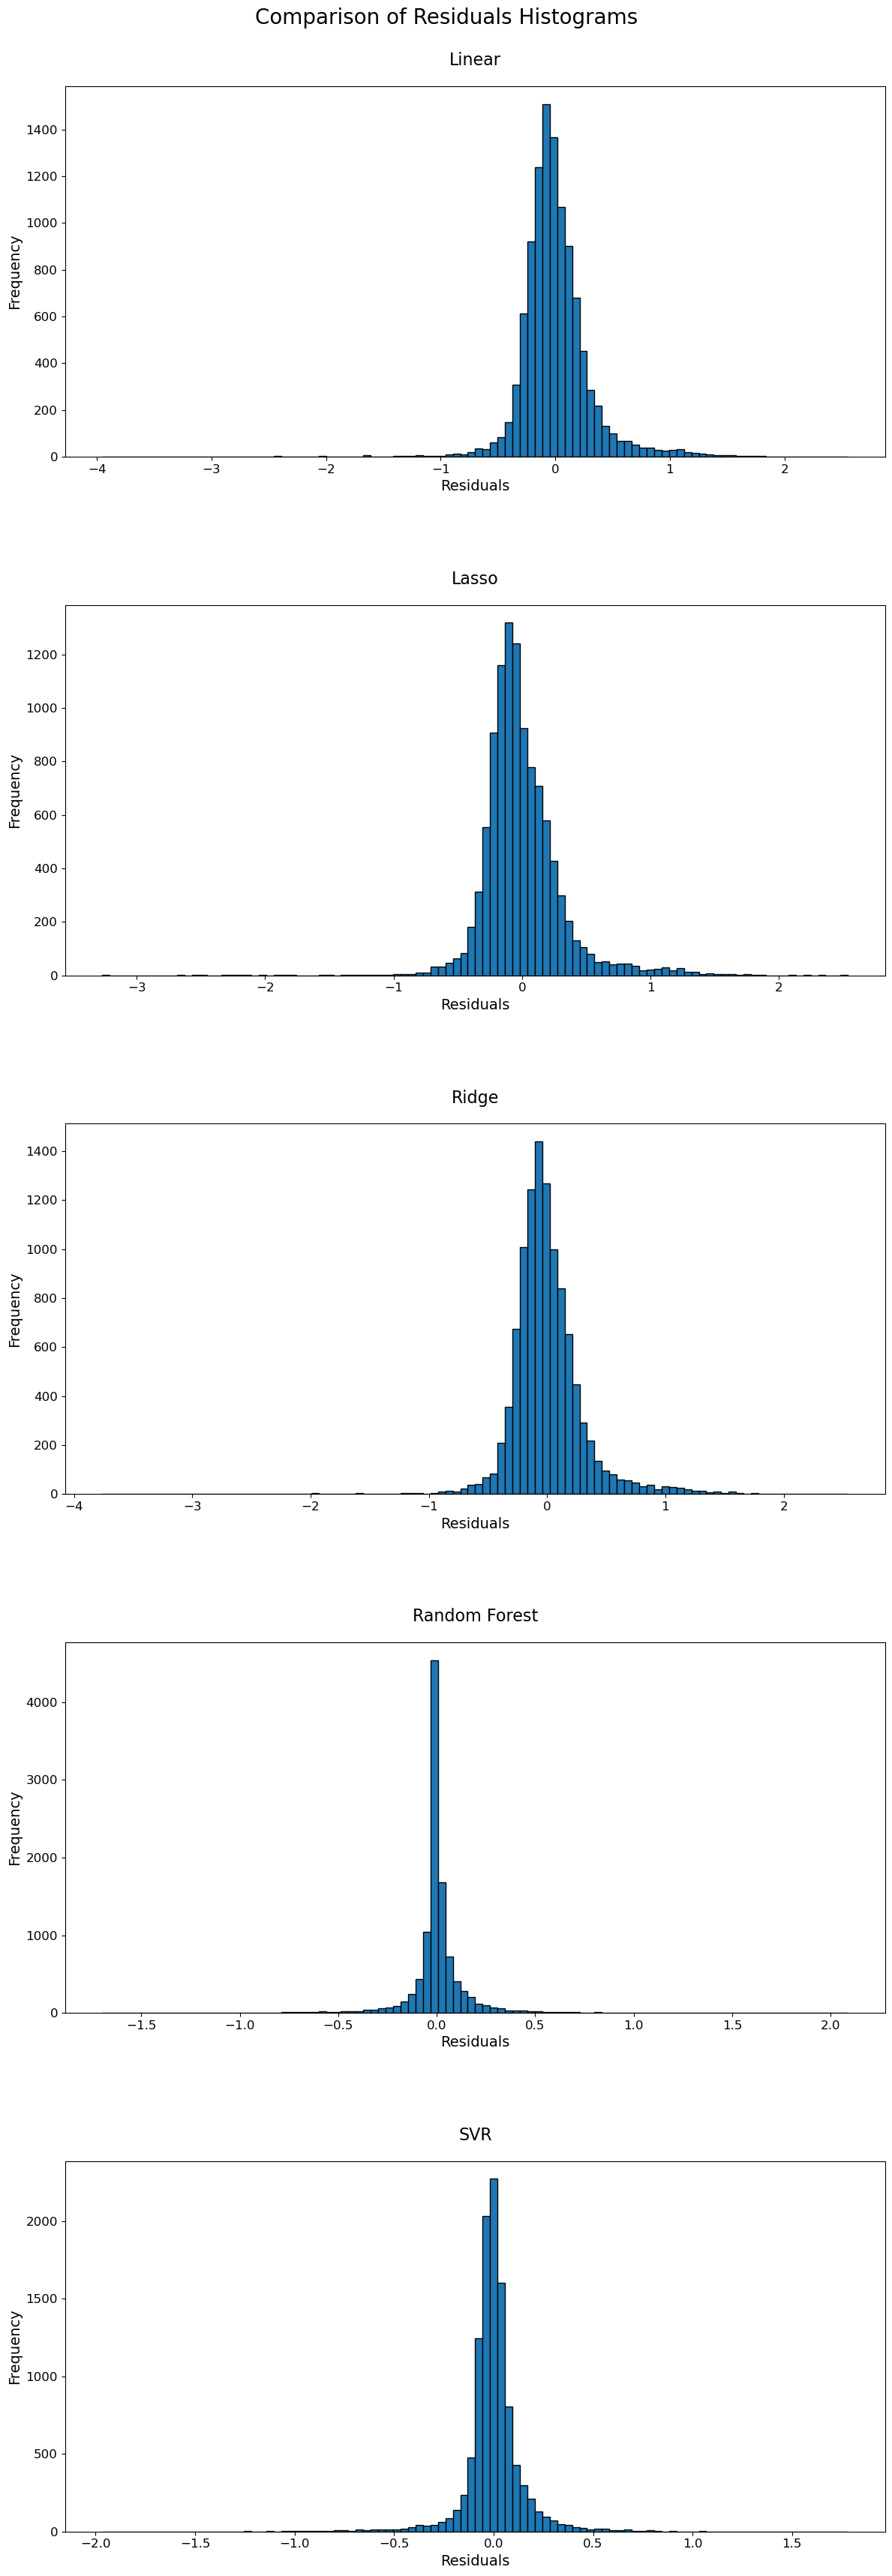

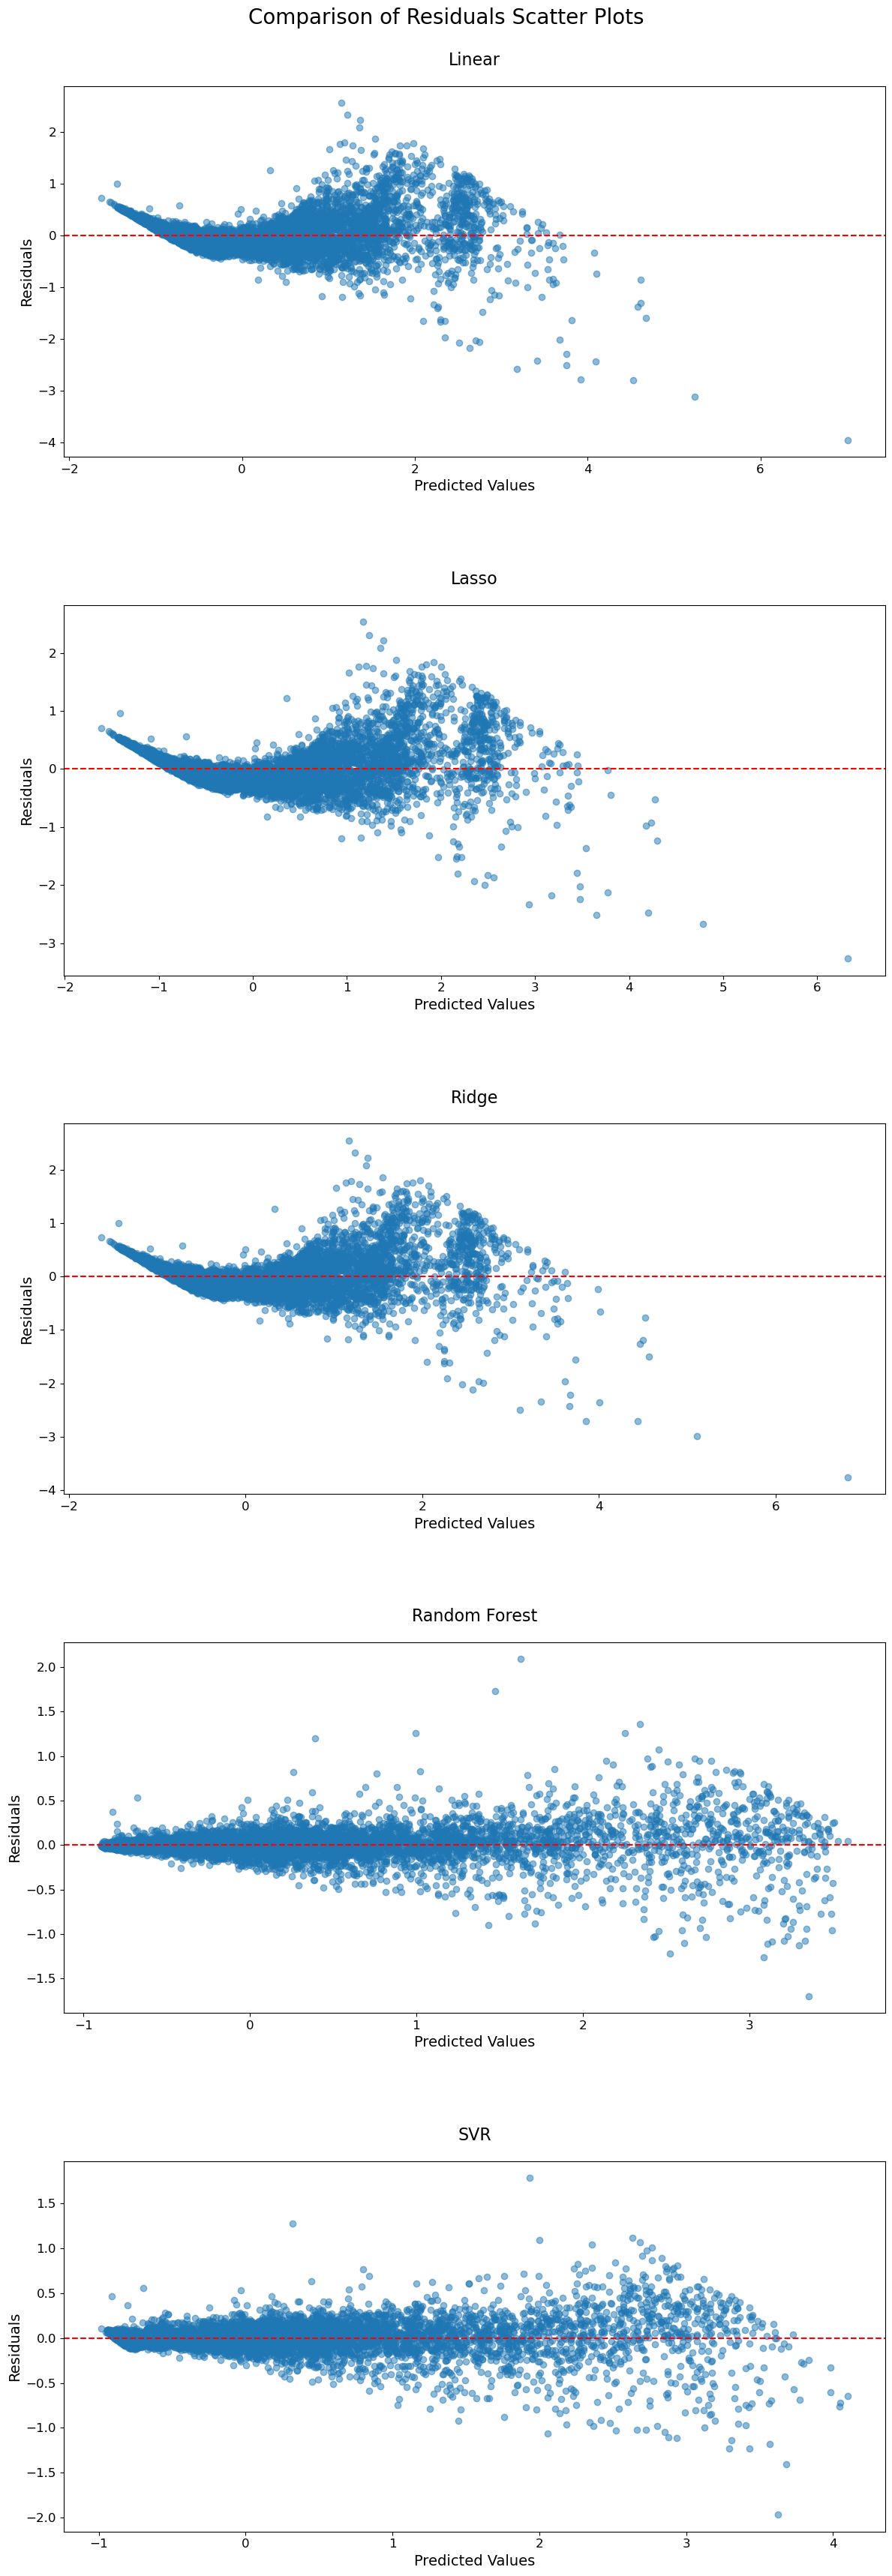

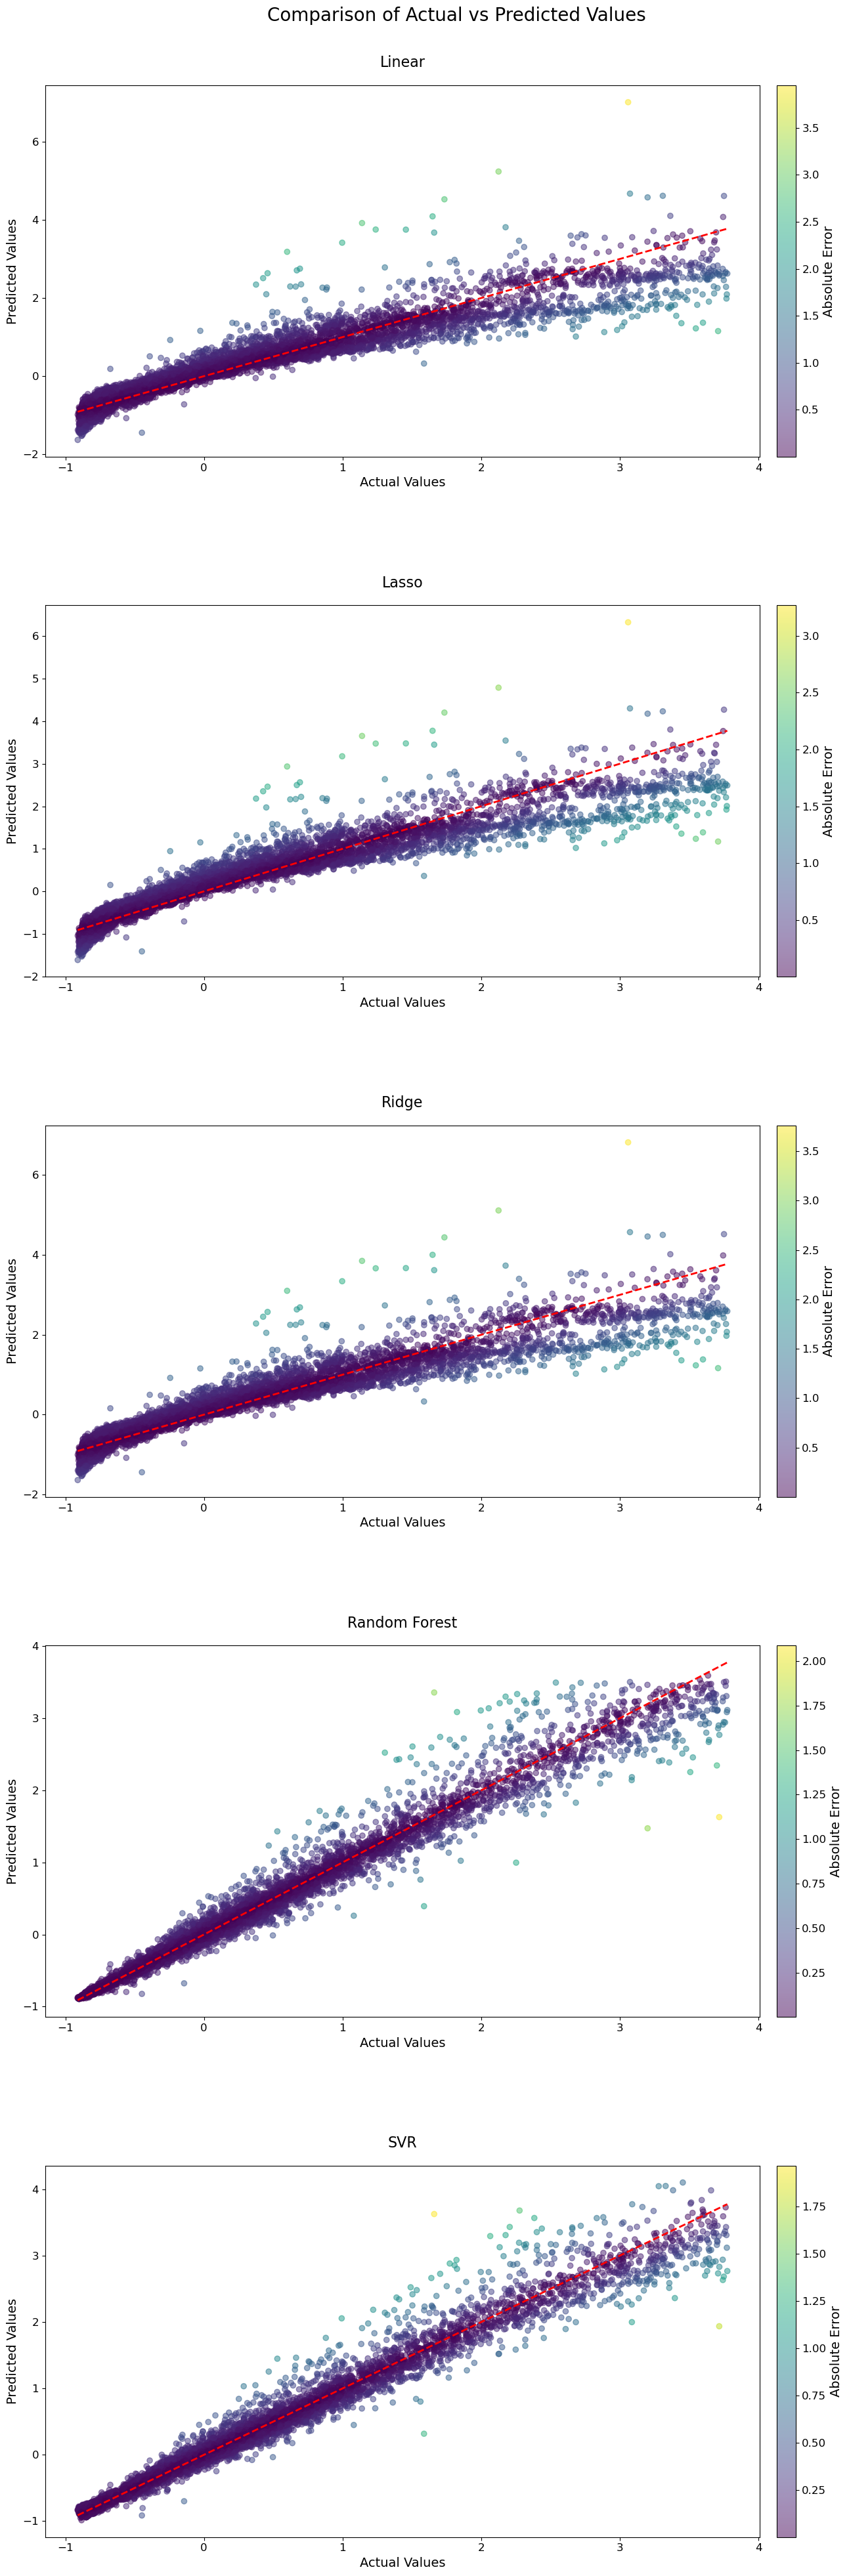

In [141]:
def plot_residuals_histograms_comparison(model_results: dict[str, dict], y_test: np.ndarray) -> None:
    """
    Plot histograms of residuals for multiple models vertically.
    
    Params:
        model_results (dict[str, dict]): Dictionary of model results, where each key is a model name
        and each value is a dictionary containing model predictions
        y_test (np.ndarray): Actual target values
    Returns:
        None
    """
    num_models = len(model_results)
    fig, axes = plt.subplots(num_models, 1, figsize=(12, 7*num_models))
    
    # Add the main title to the figure, not the subplot
    fig.suptitle('Comparison of Residuals Histograms', fontsize=20)
    
    for ax, (model_name, results) in zip(axes, model_results.items()):
        residuals = y_test - results['y_test_predictions']
        ax.hist(residuals, bins=100, edgecolor='black')
        ax.set_title(model_name, fontsize=16, pad=20)
        ax.set_ylabel('Frequency', fontsize=14)
        ax.set_xlabel('Residuals', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    # Adjust the layout to make room for the suptitle
    plt.subplots_adjust(top=0.95, hspace=0.4)
    plt.show()


def plot_residuals_scatter_comparison(model_results: dict[str, dict], y_test: np.ndarray) -> None:
    """
    Plots scatter plot of residuals vs predicted values for multiple models vertically.
    
    Params:
        model_results (dict[str, dict]): Dictionary of model results, where each key is a model name
        and each value is a dictionary containing model predictions
        y_test (np.ndarray): Actual target values
    Returns:
        None
    """
    num_models = len(model_results)
    fig, axes = plt.subplots(num_models, 1, figsize=(12, 7*num_models))
    
    # Add the main title to the figure, not the subplot
    fig.suptitle('Comparison of Residuals Scatter Plots', fontsize=20)
    
    for ax, (model_name, results) in zip(axes, model_results.items()):
        y_pred = results['y_test_predictions']
        residuals = y_test - y_pred
        ax.scatter(y_pred, residuals, alpha=0.5)
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_title(model_name, fontsize=16, pad=20)
        ax.set_ylabel('Residuals', fontsize=14)
        ax.set_xlabel('Predicted Values', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    # Adjust the layout to make room for the suptitle
    plt.subplots_adjust(top=0.95, hspace=0.4)
    plt.show()


def plot_actual_vs_predicted_comparison(model_results: dict[str, dict], y_test: np.ndarray) -> None:
    """
    Plota actual vs predicted values with error gradient for multiple models vertically.
    
    Params:
        model_results (dict[str, dict]): Dictionary of model results, where each key is a model name
        and each value is a dictionary containing model predictions
        y_test (np.ndarray): Actual target values
    Returns:
        None
    """
    num_models = len(model_results)
    fig, axes = plt.subplots(num_models, 1, figsize=(14, 8*num_models))  # Increased width for colorbar
    
    # Add the main title to the figure
    fig.suptitle('Comparison of Actual vs Predicted Values', fontsize=20)
    
    # Ensure axes is always a list, even with one subplot
    if num_models == 1:
        axes = [axes]
    
    for ax, (model_name, results) in zip(axes, model_results.items()):
        y_pred = results['y_test_predictions']
        errors = np.abs(y_test - y_pred)
        
        # Create scatter plot
        scatter = ax.scatter(y_test, y_pred, c=errors, cmap='viridis', alpha=0.5)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        ax.set_title(model_name, fontsize=16, pad=20)
        ax.set_ylabel('Predicted Values', fontsize=14)
        ax.set_xlabel('Actual Values', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Add colorbar to each subplot
        cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label('Absolute Error', fontsize=14)
    
    plt.tight_layout()
    # Adjust the layout to make room for the suptitle
    plt.subplots_adjust(top=0.95, hspace=0.4)
    plt.show()

    
    
plot_residuals_histograms_comparison(model_results, y_test)
plot_residuals_scatter_comparison(model_results, y_test)
plot_actual_vs_predicted_comparison(model_results, y_test)

### **Functions for Displaying Individual Model Perfomance Visuals**

In [142]:
def create_fit_function_equation_markdown(intercept: int, coefficient_list: list, feature_list: list = FEATURE_LIST, num_decimal_places: int = NUM_DECIMAL_PLACES) -> str:
    model_equation = f"### {TARGET_VARIABLE_NAME} = {intercept:.{num_decimal_places}f}"
    
    for i in range(len(coefficient_list)):
        model_equation += f" + {coefficient_list[i]:.{num_decimal_places}f}({feature_list[i]})"
        
    return model_equation

def print_model_evaluation_results(model_name: str, results: dict = model_results) -> None:
    """
    Displays the evaluation results for a given model.
    
    Params:
        model_name (str): Name of the model
        results (dict): Dictionary containing the evalutation results of each model
    Returns: None
    """
    display_markdown(md(f"### **Model: {model_name}**"))
    display_markdown(md(f"* #### **Train MSE:** {results[model_name]["train_mse"]:.{NUM_DECIMAL_PLACES}f}"))
    display_markdown(md(f"* #### **Test MSE:** {results[model_name]["test_mse"]:.{NUM_DECIMAL_PLACES}f}"))
    display_markdown(md(f"* #### **Test MAE:** {results[model_name]["test_mae"]:.{NUM_DECIMAL_PLACES}f}"))
    display_markdown(md(f"* #### **Test R^2:** {results[model_name]["test_r2"]:.{NUM_DECIMAL_PLACES}f}"))
    display_markdown(md(f"* #### **Test Adjusted R^2:** {results[model_name]["test_adjusted_r2"]:.{NUM_DECIMAL_PLACES}f}"))
    
    if model_name in ['Linear', 'Lasso', 'Ridge']:
        display_markdown(md(f"### **Model Equation:**"))
        display_markdown(md(create_fit_function_equation_markdown(results[model_name]["intercept"], results[model_name]["coefficients"])))
        
    
def plot_residuals_histogram(model_name: str, residuals: np.ndarray) -> None:
    """
    Display a histogram of residuals.
    
    Params:
        y_test (np.ndarray): Actual target values
        y_pred (np.ndarray): Predicted target values
        model_name (str): Name of the model
    Retruns:
        None
    """
    plt.figure(figsize = (12, 6))
    plt.hist(residuals, bins = 100)
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Residuals ({model_name})')
    plt.grid(True)
    plt.show() 
    

def plot_residuals_scatter(model_name: str, y_pred: np.ndarray, residuals: np.ndarray) -> None:
    """
    Displays a scatter plot of residuals vs predicted values.
    
    Params:
        y_pred (np.ndarray): Predicted target values
        residuals (np.ndarray): Residuals (actual - predicted)
        model_name (str): Name of the model
    Retruns:
        None
    """
    plt.figure(figsize = (12, 6))
    plt.scatter(y_pred, residuals, alpha = 0.7)
    plt.hlines(y = 0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles = 'dashed', colors = 'red')
    plt.xlabel('Predicted Target Values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(f'Residual Plot ({model_name})')
    plt.grid(True)
    plt.show()
    
    
def plot_actual_vs_predicted(model_name: str, y_test: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Displays a plot of actual vs predicted values with error gradient.
    
    Params:
        y_test (np.ndarray): Actual target values
        y_pred (np.ndarray): Predicted target values
        model_name (str): Name of the model
    Returns:
        None
    """
    errors = np.abs(y_test - y_pred)
    plt.figure(figsize=(13, 6))
    scatter = plt.scatter(y_test, y_pred, c = errors, cmap = 'viridis', alpha = 0.7)
    plt.colorbar(scatter, label = 'Absolute Error')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Target Values')
    plt.ylabel('Predicted Target Values')
    plt.title(f'Actual vs. Predicted with Error Gradient ({model_name})')
    plt.grid(True)
    plt.show()

## **Individual Model Evaluation and Performance Visualizations**

### **Linear Model**

### **Model: Linear**

* #### **Train MSE:** 0.0927196

* #### **Test MSE:** 0.0967574

* #### **Test MAE:** 0.2030547

* #### **Test R^2:** 0.9032426

* #### **Test Adjusted R^2:** 0.9031704

### **Model Equation**

### price = -0.7732221 + -0.1960899(MedInc) + 0.0171985(HouseAge) + 1.2591654(AveRooms) + -0.0454390(AveBedrms) + 0.0392448(Population) + 0.0807502(AveOccup) + 0.1261156(Latitude)

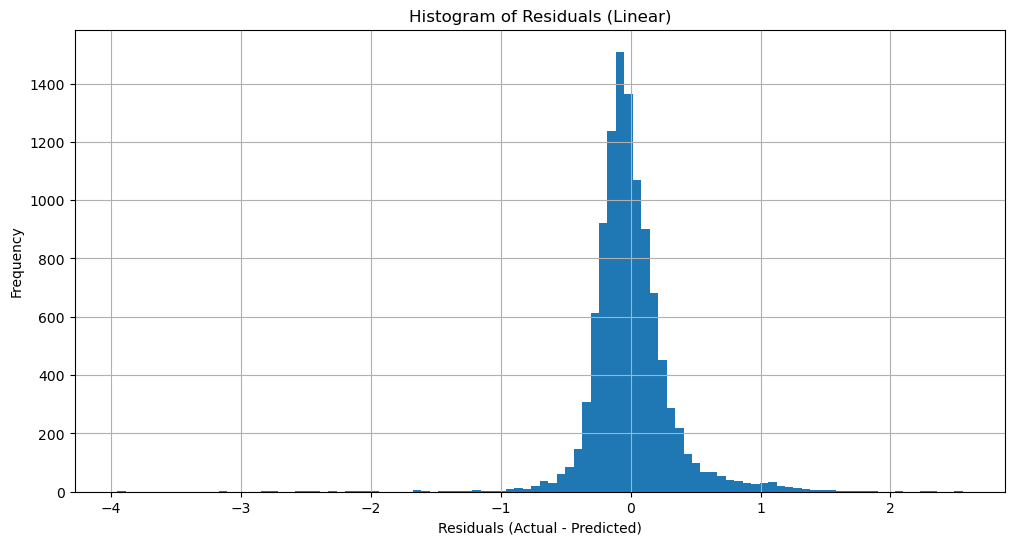

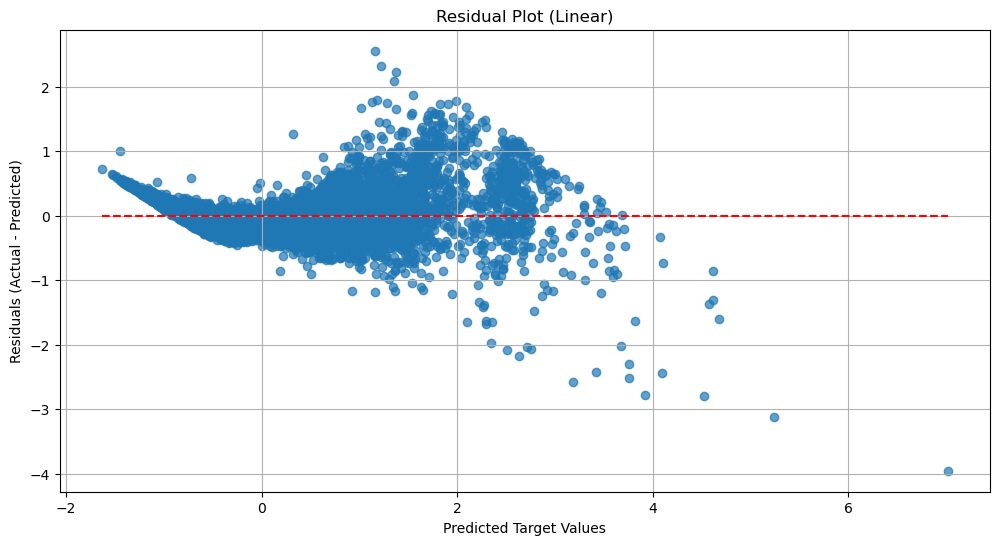

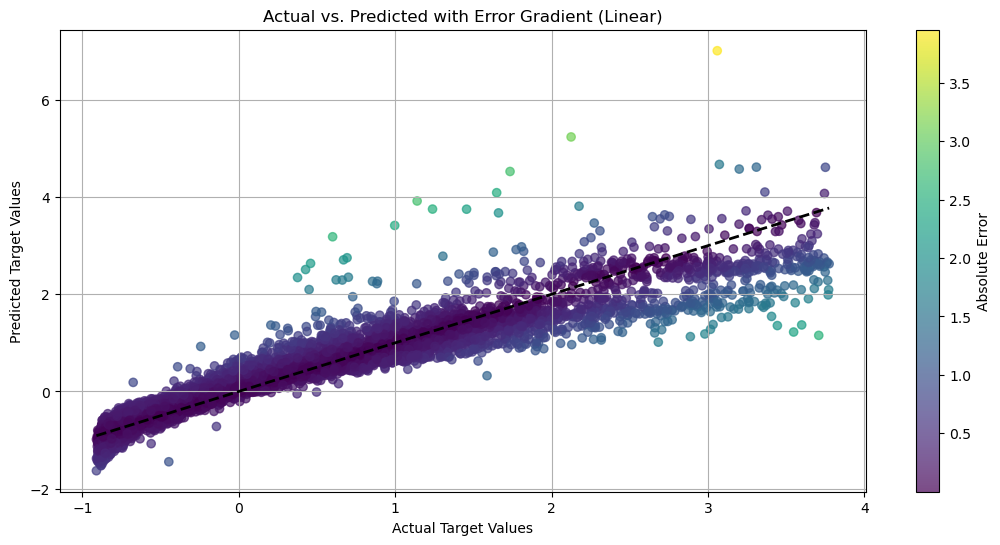

In [130]:
linear_model_name: str = "Linear"

linear_y_train_predictions = model_results[linear_model_name]["y_train_predictions"]
linear_y_test_predictions = model_results[linear_model_name]["y_test_predictions"]
linear_residuals = y_test - linear_y_test_predictions


print_model_evaluation_results(linear_model_name)
plot_residuals_histogram(linear_model_name, linear_residuals)
plot_residuals_scatter(linear_model_name, linear_y_test_predictions, linear_residuals)
plot_actual_vs_predicted(linear_model_name, y_test, linear_y_test_predictions)


### **Lasso Model**

### **Model: Lasso**

* #### **Train MSE:** 0.0955240

* #### **Test MSE:** 0.1002120

* #### **Test MAE:** 0.2120405

* #### **Test R^2:** 0.8997880

* #### **Test Adjusted R^2:** 0.8997133

### **Model Equation**

### price = -0.7123440 + -0.0000000(MedInc) + 0.0000000(HouseAge) + 1.0244277(AveRooms) + -0.0000000(AveBedrms) + 0.0299107(Population) + 0.0728509(AveOccup) + 0.1238497(Latitude)

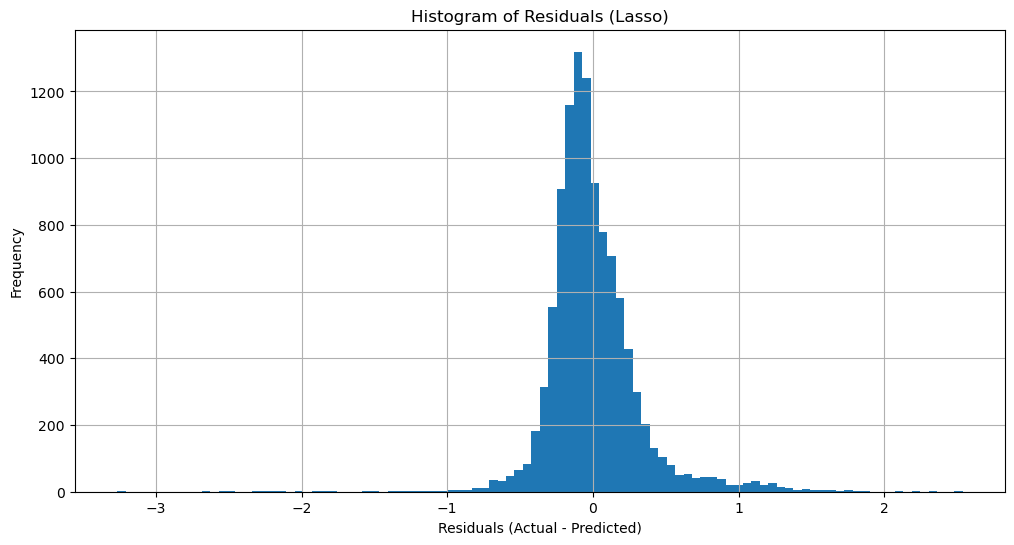

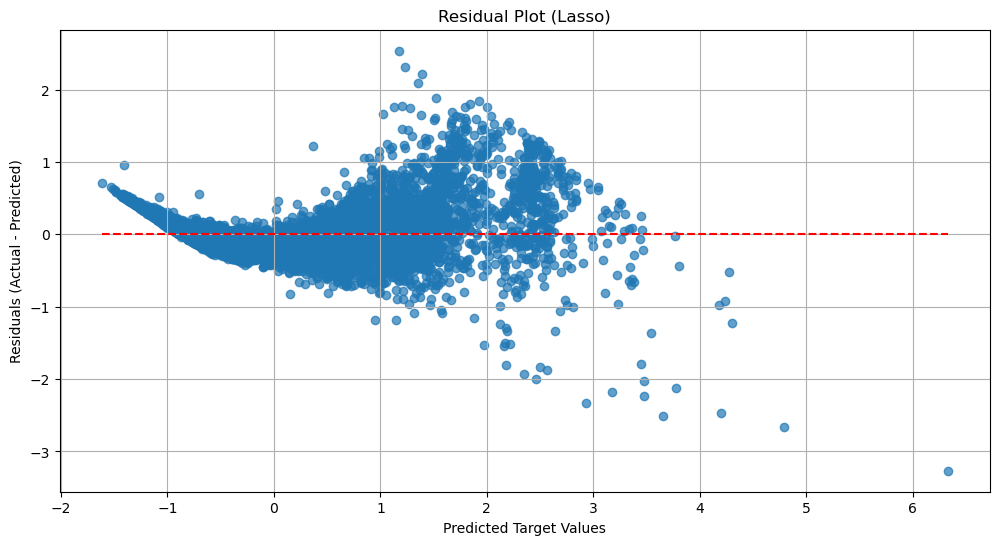

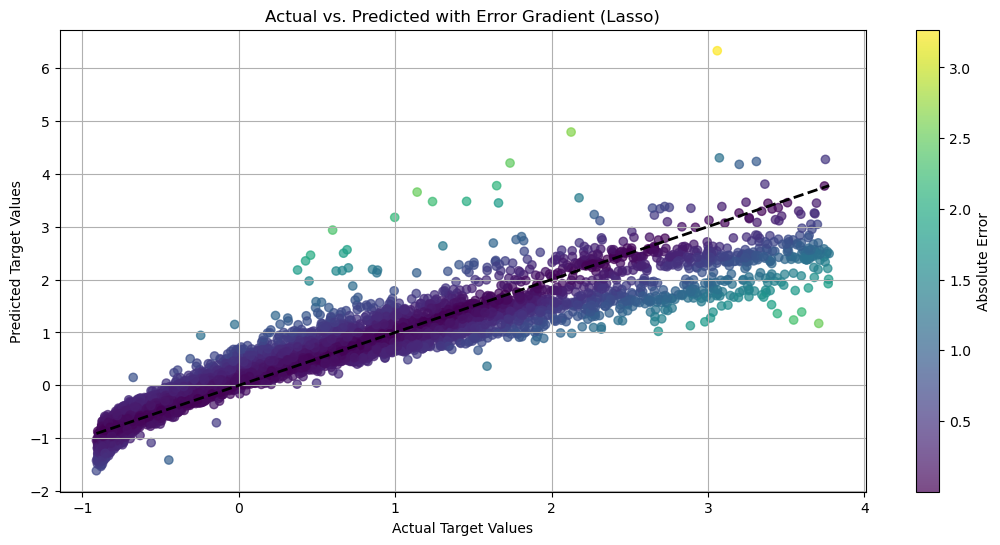

In [131]:
lasso_model_name: str = "Lasso"

lasso_y_train_predictions = model_results[lasso_model_name]["y_train_predictions"]
lasso_y_test_predictions = model_results[lasso_model_name]["y_test_predictions"]
lasso_residuals = y_test - lasso_y_test_predictions


print_model_evaluation_results(lasso_model_name)
plot_residuals_histogram(lasso_model_name, lasso_residuals)
plot_residuals_scatter(lasso_model_name, lasso_y_test_predictions, lasso_residuals)
plot_actual_vs_predicted(lasso_model_name, y_test, lasso_y_test_predictions)

### **Ridge Model**

### **Model: Ridge**

* #### **Train MSE:** 0.0929200

* #### **Test MSE:** 0.0971049

* #### **Test MAE:** 0.2053125

* #### **Test R^2:** 0.9028951

* #### **Test Adjusted R^2:** 0.9028226

### **Model Equation**

### price = -0.7683878 + -0.1326390(MedInc) + 0.0130418(HouseAge) + 1.1944347(AveRooms) + -0.0416862(AveBedrms) + 0.0384626(Population) + 0.0796566(AveOccup) + 0.1264939(Latitude)

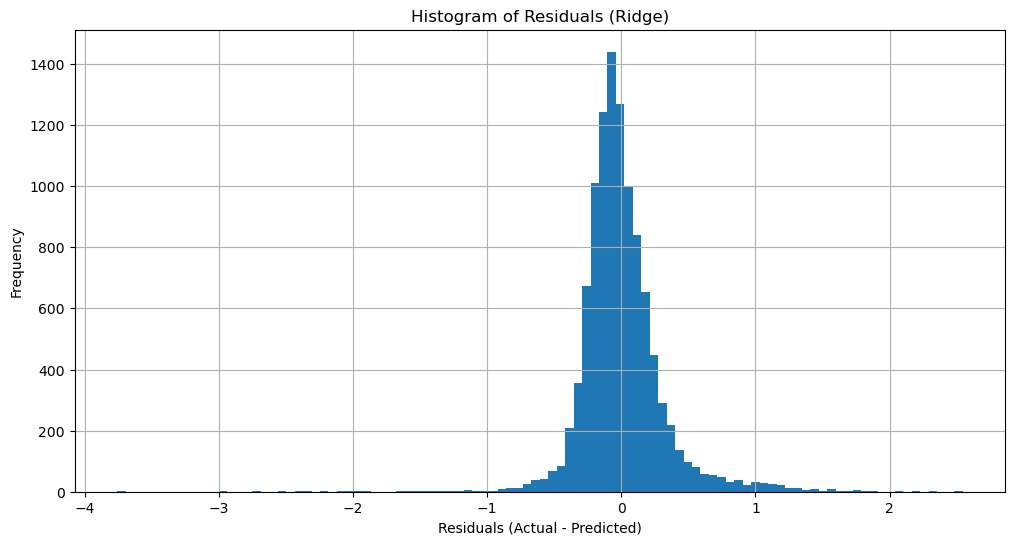

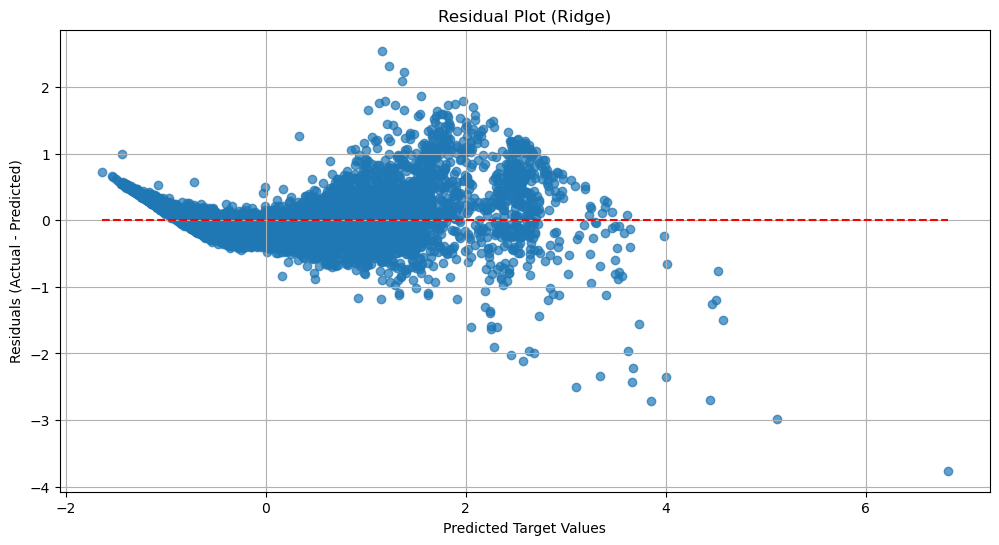

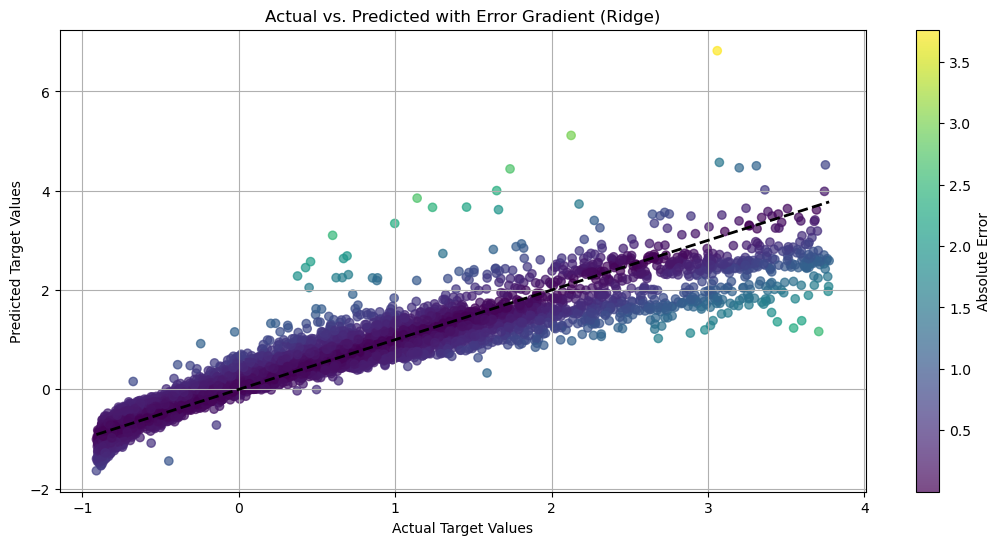

In [132]:
ridge_model_name: str = "Ridge"

ridge_y_train_predictions = model_results[ridge_model_name]["y_train_predictions"]
ridge_y_test_predictions = model_results[ridge_model_name]["y_test_predictions"]
ridge_residuals = y_test - ridge_y_test_predictions


print_model_evaluation_results(ridge_model_name)
plot_residuals_histogram(ridge_model_name, ridge_residuals)
plot_residuals_scatter(ridge_model_name, ridge_y_test_predictions, ridge_residuals)
plot_actual_vs_predicted(ridge_model_name, y_test, ridge_y_test_predictions)

### **Random Forest Model**

### **Model: Random Forest**

* #### **Train MSE:** 0.0026932

* #### **Test MSE:** 0.0210792

* #### **Test MAE:** 0.0719748

* #### **Test R^2:** 0.9789208

* #### **Test Adjusted R^2:** 0.9789051

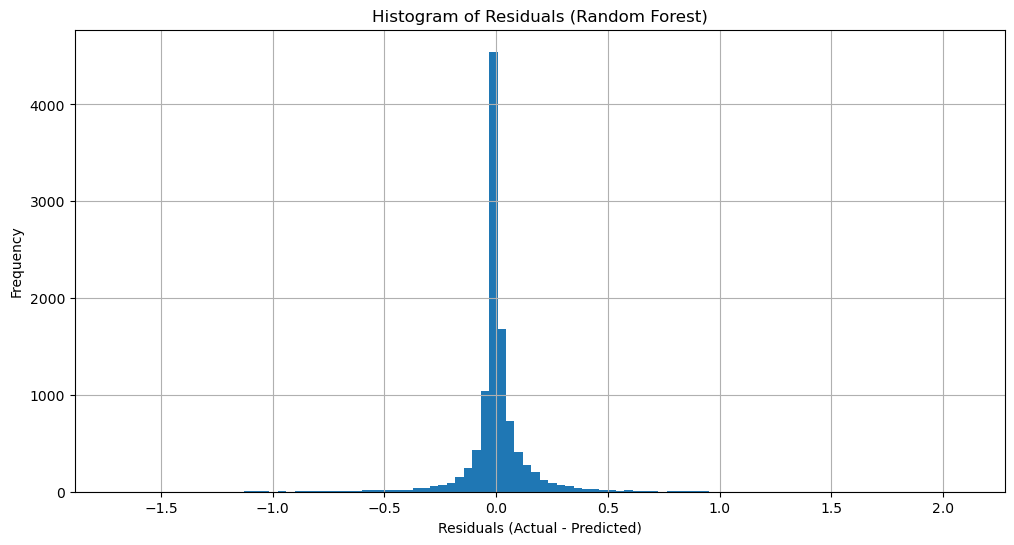

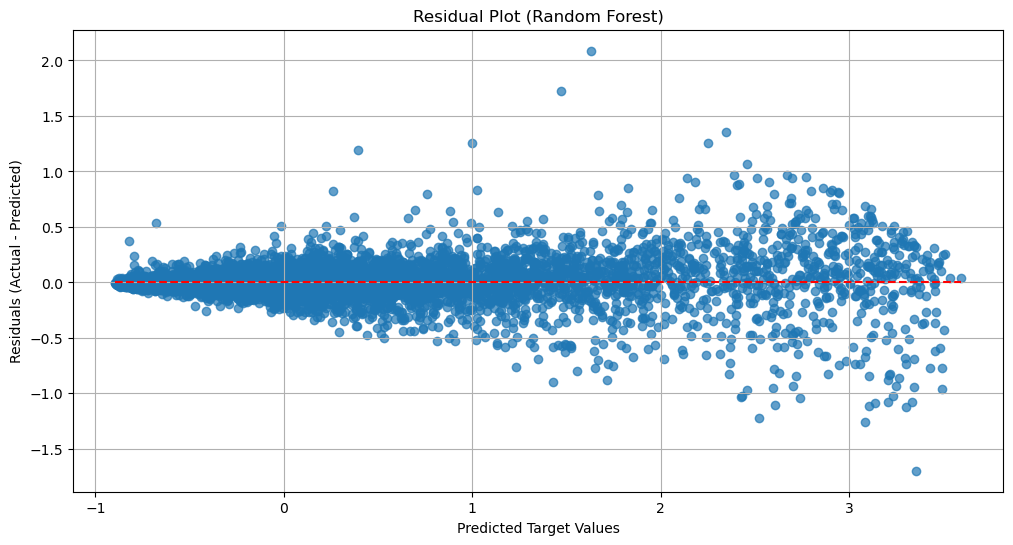

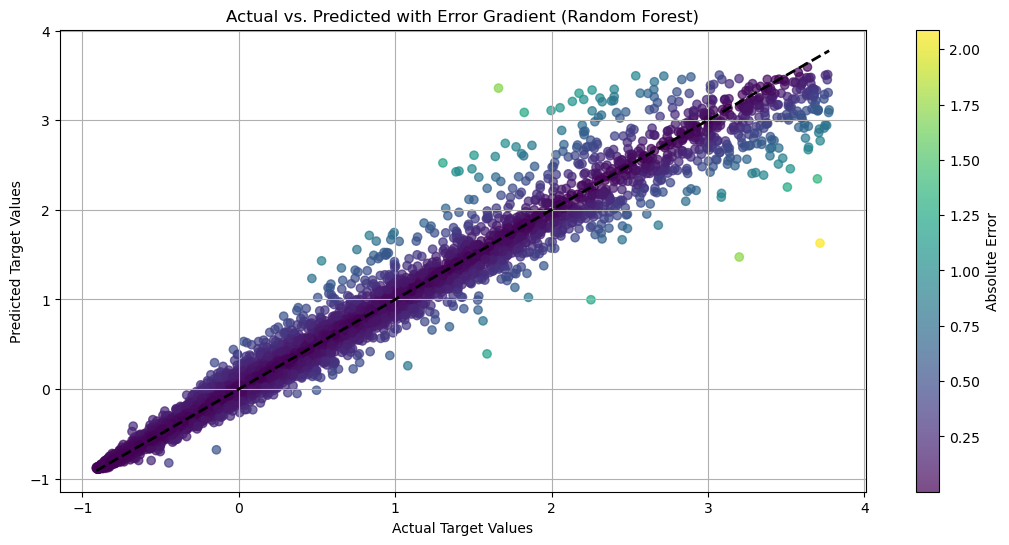

In [133]:
random_forest_model_name: str = "Random Forest"

random_forest_y_train_predictions = model_results[random_forest_model_name]["y_train_predictions"]
random_forest_y_test_predictions = model_results[random_forest_model_name]["y_test_predictions"]
random_forest_residuals = y_test - random_forest_y_test_predictions


print_model_evaluation_results(random_forest_model_name)
plot_residuals_histogram(random_forest_model_name, random_forest_residuals)
plot_residuals_scatter(random_forest_model_name, random_forest_y_test_predictions, random_forest_residuals)
plot_actual_vs_predicted(random_forest_model_name, y_test, random_forest_y_test_predictions)

### **Support Vector Model**

### **Model: SVR**

* #### **Train MSE:** 0.0197964

* #### **Test MSE:** 0.0225600

* #### **Test MAE:** 0.0864844

* #### **Test R^2:** 0.9774400

* #### **Test Adjusted R^2:** 0.9774231

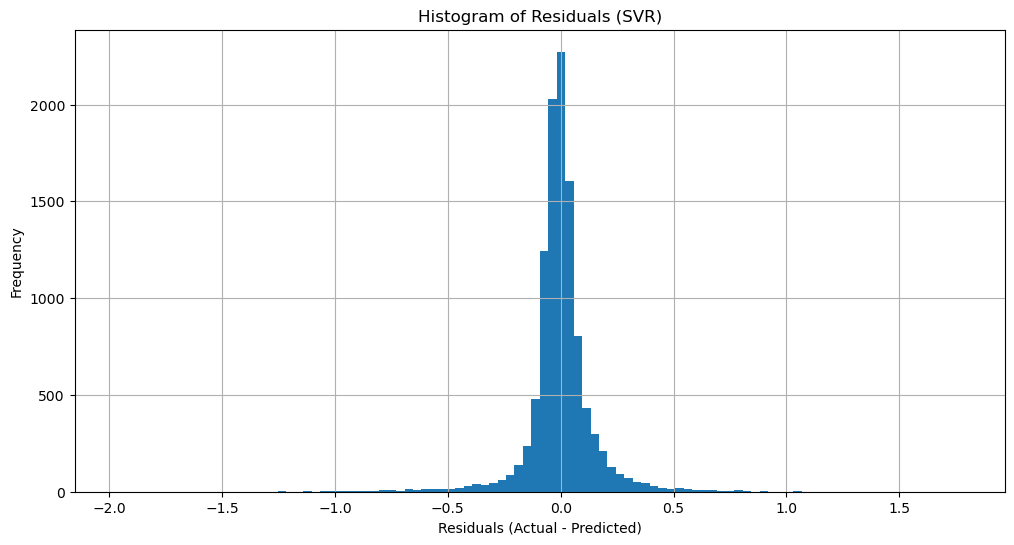

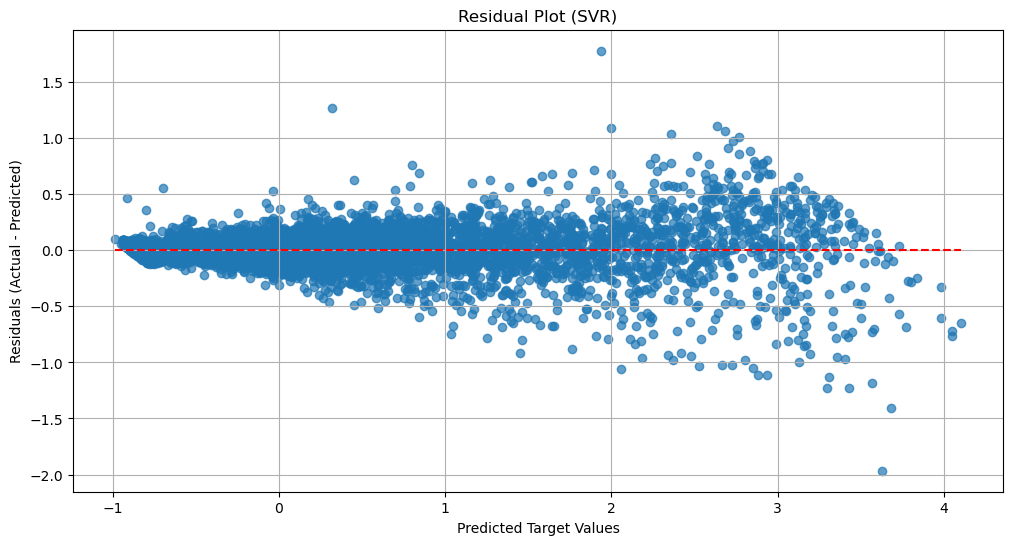

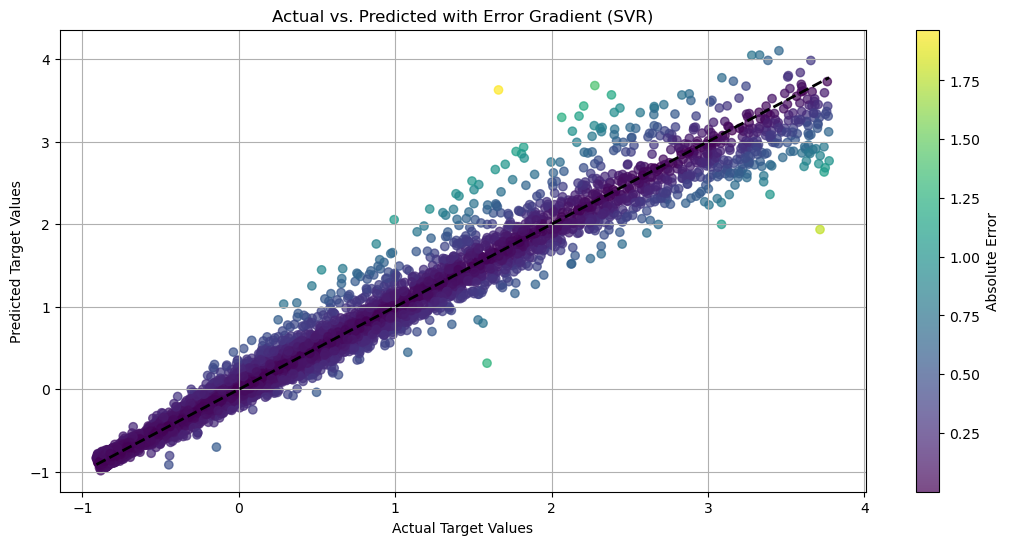

In [134]:
svr_model_name: str = "SVR"

svr_y_train_predictions = model_results[svr_model_name]["y_train_predictions"]
svr_y_test_predictions = model_results[svr_model_name]["y_test_predictions"]
svr_residuals = y_test - svr_y_test_predictions


print_model_evaluation_results(svr_model_name)
plot_residuals_histogram(svr_model_name, svr_residuals)
plot_residuals_scatter(svr_model_name, svr_y_test_predictions, svr_residuals)
plot_actual_vs_predicted(svr_model_name, y_test, svr_y_test_predictions)

## **Save Best Model**

In [ ]:
SAVE_FILE_NAME: str = "diamond_price_regression_model.pkl"

def save_model_pickle(file_name: str = SAVE_FILE_NAME, model_name: str = best_model, results: dict[str, dict] = model_results) -> None:
    """
    Saves the best performing model to a pickle file.
    
    Params:
        file_name (str): Name of the pickle file to save the model to
        model_name (str): Name of the model that is about to be saved
        results (dict[str, dict]): Dictionary containing the model object, predictions on the testing data, and other model perfomance data
    Returns:
        None
    """
    with open(file_name, 'wb') as file:
        pickle.dump(results[model_name], file)
        

def save_model_joblib(file_name: str, model_name: str = best_model, results: dict[str, dict] = model_results) -> None:
    """
    Saves the best performing model to a joblib file.
    
    Params:
        file_name (str): Name of the joblib file to save the model to
        model_name (str): Name of the model that is about to be saved
        results (dict[str, dict]): Dictionary containing the model object, predictions on the testing data, and other model perfomance data
    Returns:
        None
    """
    dump(results[model_name], file_name)